## Load Libraries and Set Up Environment


In [1]:
import random
import numpy as np
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import requests
from io import BytesIO

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import decode_predictions


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [2]:
print(tf.version.VERSION)

2.16.1


## Base model

In [3]:
# Set variables
SIZE = 224
image_size = (SIZE, SIZE)
CLASSES_NUM = 1000

DATADIR = 'dataset'
OUTPUTS = 'outputs'

In [ ]:
#  Initialize a MobileNetV3Small base model for image classification tasks.
base_model = MobileNetV3Small(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=CLASSES_NUM,
    classifier_activation="softmax",
)

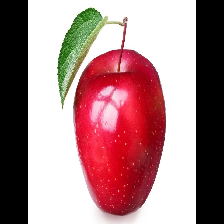

In [5]:
# Take an image from our dataset
filename = f'{DATADIR}/train/apple/Image_2.jpg'
img = load_img(filename, target_size=image_size)
img

In [6]:
def base_inference(image):
    """ Inference function for the MobileNetV3Small model 
    Parameters:
    image: Input image.

    Returns:
        A list of predicted class labels and corresponding probabilities.
    """
    # Input prepare
    x = keras.utils.img_to_array(image)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Run inference
    pred = base_model.predict(x)
    return decode_predictions(pred)

In [ ]:
base_inference(img)
""" Outputs:
[[('n07745940', 'strawberry', 0.13018553),
  ('n12620546', 'hip', 0.10689251),
  ('n07720875', 'bell_pepper', 0.055708233),
  ('n07768694', 'pomegranate', 0.046514604),
  ('n07742313', 'Granny_Smith', 0.038801577)]]
"""

The base model misclassified the image from our dataset.  
Let's see if the base model can do a better job with an image from the Internet.  
To do this, we will add a function for obtaining an image from the network.

In [8]:
def load_image_from_url(url):
    """ Get an image by url """
    response = requests.get(url)
    img_bytes = BytesIO(response.content)
    img = load_img(img_bytes, target_size=image_size)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[[('n07720875', 'bell_pepper', 0.23412071),
  ('n07745940', 'strawberry', 0.15218116),
  ('n07718472', 'cucumber', 0.054930873),
  ('n07753592', 'banana', 0.05265097),
  ('n07742313', 'Granny_Smith', 0.048394263)]]

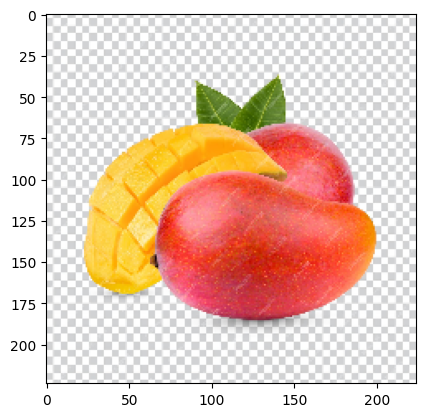

In [9]:
# Take an image from the Internet
url = 'https://img.freepik.com/premium-psd/mango-fruit-sliced-with-leaves-isolated-premium-psd_328278-536.jpg?w=1380'
img = load_image_from_url(url)
plt.imshow(img)

base_inference(img)

As we see the result of the baseline model is unsatisfactory.
I need to find a solution to improve the outcome.

## Transfer learning

In [11]:
# Variables for transfer learning
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
CLASSES_NUM = 36

### Generate Datasets

In [12]:
# Let's create a training ImageDataGenerator with data augmentation
train_gen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,   
    
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    f'{DATADIR}/train',
    target_size=image_size,
    batch_size=batch_size
)

Found 3115 images belonging to 36 classes.


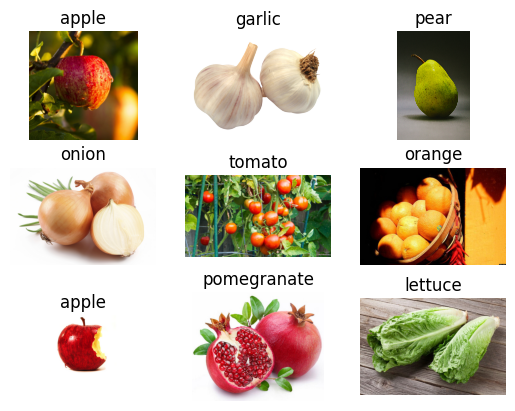

In [13]:
# Data Visualization
for index, filename in enumerate(random.sample(train_ds.filenames, 9)):
    im = PIL.Image.open(f'{DATADIR}/train/{filename}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title(filename.split('/')[0])
    plt.axis('off')
    
plt.show()

In [14]:
# ImageDataGenerator for validation
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    f'{DATADIR}/validation',
    target_size=image_size,
    batch_size=batch_size
)

Found 351 images belonging to 36 classes.


In [15]:
# ImageDataGenerator for testing
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_ds = test_gen.flow_from_directory(
    f'{DATADIR}/test',
    target_size=image_size,
    batch_size=batch_size
)

Found 359 images belonging to 36 classes.


### Build a model

In [16]:
# Adding callbaks
early_stopping = EarlyStopping(monitor='loss', patience=3)

checkpoint_path = f'{OUTPUTS}/best_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks_list = [
    early_stopping,
    checkpoint
]

In [17]:
def make_model(learning_rate=0.001, droprate=0.2):
    """ Creates a custom MobileNetV3Small-based deep learning model """
    base_model = MobileNetV3Small(
        weights='imagenet',
        input_shape=(SIZE, SIZE, 3),
        include_top=False
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(SIZE, SIZE, 3))
    base = base_model(inputs, training=False)
    
    # Add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base)
    x = Dense(100, activation='relu')(x)
    x = Dropout(droprate)(x)
    outputs = Dense(CLASSES_NUM, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model


mob_v3_model = make_model()

In [18]:
mob_v3_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         3,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,456 (3.82 MB)

 Trainable params: 61,336 (239.59 KB)

 Non-trainable params: 939,120 (3.58 MB)

### Train the model

In [19]:
epochs = 50
mob_v3_model.fit(
            train_ds, 
            epochs=epochs,
            validation_data=val_ds,
            callbacks=callbacks_list)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 625ms/step - accuracy: 0.2088 - loss: 3.0862 - val_accuracy: 0.7863 - val_loss: 0.9014
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 604ms/step - accuracy: 0.6443 - loss: 1.2543 - val_accuracy: 0.8547 - val_loss: 0.5485
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 601ms/step - accuracy: 0.7242 - loss: 0.9429 - val_accuracy: 0.8803 - val_loss: 0.4150
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 611ms/step - accuracy: 0.7846 - loss: 0.7276 - val_accuracy: 0.8889 - val_loss: 0.3621
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 605ms/step - accuracy: 0.8038 - loss: 0.6684 - val_accuracy: 0.8860 - val_loss: 0.3246
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 608ms/step - accuracy: 0.8331 - loss: 0.5494 - val_accuracy: 0.8860 - val_loss: 0.3060
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 603ms/step - accuracy: 0.8430 - loss: 0.5234 - val_accuracy: 0.9003 - val_loss: 0.2842
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 605ms/step - accuracy: 0.8472 - loss: 0.4954 - val_accu

### Metrics

In [20]:
def get_metrics(model):
    """ Show metrics """
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

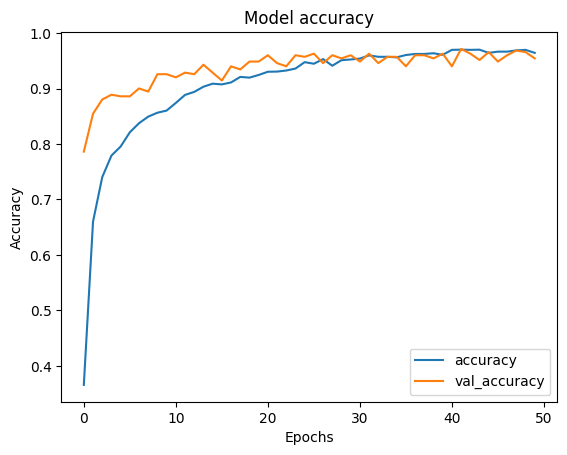

In [21]:
get_metrics(mob_v3_model)

In [22]:
# Load the best model from a file.
mob_v3_model = keras.models.load_model(checkpoint_path)

In [23]:
# Evaluates the trained model on the test dataset, printing out metrics such as accuracy and loss.
eval_metrics = mob_v3_model.evaluate(test_ds)
dict(zip(mob_v3_model.metrics_names, eval_metrics))

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 583ms/step - accuracy: 0.9749 - loss: 0.1181


{'loss': 0.14080321788787842, 'compile_metrics': 0.9721448421478271}

The final model achieves an accuracy of approximately 97% on the test dataset.

### Inference

In [24]:
# Prepare labels
labels = {value:key for key, value in train_ds.class_indices.items()}
labels

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

In [25]:
def get_predict(model, img):
    """ Run inference """
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y_pred = model.predict(x)
    
    return labels[y_pred[0].argmax()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'mango'

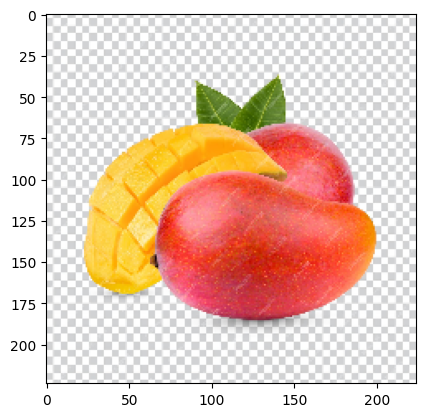

In [26]:
# Let's check the result of the trained model
url = 'https://img.freepik.com/premium-psd/mango-fruit-sliced-with-leaves-isolated-premium-psd_328278-536.jpg?w=1380'
img = load_image_from_url(url)
plt.imshow(img)

get_predict(mob_v3_model, img)

A brilliant result! We completed the task.